In [1]:
import sys
sys.path.insert(0, '/home/sxh/Research/AttentiveFP/code',)

import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1"

In [2]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight


In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [4]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

In [5]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()

        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss



def predict(model, dataset):
    model.eval()
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
        
    preds = []
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        probs = F.softmax(mol_prediction,dim=-1).data.cpu().numpy()[:,1]
        preds.append(probs)
    return np.concatenate(preds,axis=0)

number of all smiles:  2050
not successfully processed smiles:  O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
not successfully processed smiles:  c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
not successfully processed smiles:  Cc1nc(sc1)\[NH]=C(\N)N


RDKit ERROR: [08:35:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit WARNING: [08:35:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:29] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [08:35:29] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit WARNING: [08:35:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:29] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WA

not successfully processed smiles:  s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
not successfully processed smiles:  c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1ccccc1
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
not successfully processed smiles:  s1cc(nc1\[NH]=C(\N)N)C
not successfully processed smiles:  c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC


RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:35:30] WARNING: not r

number of successfully processed smiles:  2039


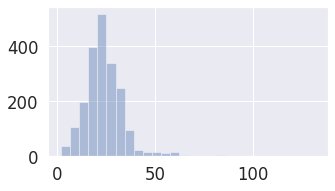

In [6]:
tasks = ['BBBP']
raw_filename = "/home/sxh/Research/AttentiveFP/data/BBBP.csv"


feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [7]:
random_seed = 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [8]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,BBBP,smiles,cano_smiles
372,0,CN[C@H](CC(C)C)C(=O)NC1[C@H](O)c2ccc(Oc3cc4cc(...,CN[C@H](CC(C)C)C(=O)NC1C(=O)N[C@@H](CC(N)=O)C(...
826,0,CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC3C[C@@H](C\C=C...,CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC1C[C@@H](C/C=C...
932,0,CCCCCCCCCC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](...,CCCCCCCCCC(=O)N[C@H]1[C@H](Oc2c3cc4cc2Oc2ccc(c...


In [9]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])


In [12]:
remained_df = remained_df.reset_index(drop=True)

file_path = "/raid/shenwanxiang/08_Robustness/dataset_induces/split"
random_seeds = [2, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


task_name = 'BBBP'


for seed in random_seeds:
    
    train_path = os.path.join(file_path, task_name,"%s" % seed, "train.csv")
    valid_path = os.path.join(file_path, task_name,"%s" % seed, "val.csv")
    test_path = os.path.join(file_path, task_name,"%s" % seed, "test.csv")

    pred_valid_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_pred_val.csv")
    pred_test_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_pred_test.csv")
    
    saved_valid_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_saved_val.csv")
    saved_test_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_saved_test.csv")
    
    
    df_train = pd.read_csv(train_path)
    df_valid = pd.read_csv(valid_path)
    df_test = pd.read_csv(test_path)

    print(seed, task_name)
    if (os.path.exists(pred_test_path)) & (os.path.exists(pred_valid_path)):
        continue



    test_df = remained_df[remained_df.smiles.isin(df_test.smiles)].reset_index(drop=True)
    valid_df = remained_df[remained_df.smiles.isin(df_valid.smiles)].reset_index(drop=True)
    train_df = remained_df[remained_df.smiles.isin(df_train.smiles)].reset_index(drop=True)

    weights = []
    for i,task in enumerate(tasks):    
        negative_df = train_df[train_df[task] == 0][["smiles",task]]
        positive_df = train_df[train_df[task] == 1][["smiles",task]]
        weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                        (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])


    print(len(train_df),len(valid_df),len(test_df),)

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
    num_atom_features = x_atom.shape[-1]
    num_bond_features = x_bonds.shape[-1]

    loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight)) for weight in weights]
    model = Fingerprint(radius, T, num_atom_features,num_bond_features,
                fingerprint_dim, output_units_num, p_dropout)
    model.cuda()
    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

    best_param ={}
    best_param["roc_epoch"] = 0
    best_param["loss_epoch"] = 0
    best_param["valid_roc"] = 0
    best_param["valid_loss"] = 9e8

    for epoch in range(epochs):    
        train_roc, train_prc, train_precision, train_recall, train_loss = eval(model, train_df)
        valid_roc, valid_prc, valid_precision, valid_recall, valid_loss = eval(model, valid_df)
        train_roc_mean = np.array(train_roc).mean()
        valid_roc_mean = np.array(valid_roc).mean()

        if valid_roc_mean > best_param["valid_roc"]:
            best_param["roc_epoch"] = epoch
            best_param["valid_roc"] = valid_roc_mean
            if valid_roc_mean > 0.78:
                 torch.save(model, '/raid/shenwanxiang/08_Robustness/saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')

        if valid_loss < best_param["valid_loss"]:
            best_param["loss_epoch"] = epoch
            best_param["valid_loss"] = valid_loss

        print("EPOCH:\t"+str(epoch)+'\n'\
            +"train_roc"+":"+str(train_roc)+'\n'\
            +"valid_roc"+":"+str(valid_roc)+'\n')
        if epoch - best_param["roc_epoch"] > 10:        
            break

        train(model, train_df, optimizer, loss_function)

    # evaluate model
    best_model = torch.load('/raid/shenwanxiang/08_Robustness/saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

    test_roc, test_prc, test_precision, test_recall, test_losses = eval(best_model, test_df)

    print("best epoch:"+str(best_param["roc_epoch"])
          +"\n"+"test_roc:"+str(test_roc)
          +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
         )


    pred_test = predict(best_model, test_df)
    pd.DataFrame(pred_test, index = test_df['smiles'],
                 columns = [tasks]).to_csv(pred_test_path)

    pd.DataFrame(test_df[tasks].values, index = test_df['smiles'],
                 columns = [tasks]).to_csv(saved_test_path)

    pred_valid = predict(best_model, valid_df)
    pd.DataFrame(pred_valid, index = valid_df['smiles'], 
                 columns = [tasks]).to_csv(pred_valid_path)

    pd.DataFrame(valid_df[tasks].values, index = valid_df['smiles'],
                 columns = [tasks]).to_csv(saved_valid_path)

2 BBBP
16 BBBP
32 BBBP
64 BBBP
128 BBBP
256 BBBP
512 BBBP
1024 BBBP
2048 BBBP
4096 BBBP
